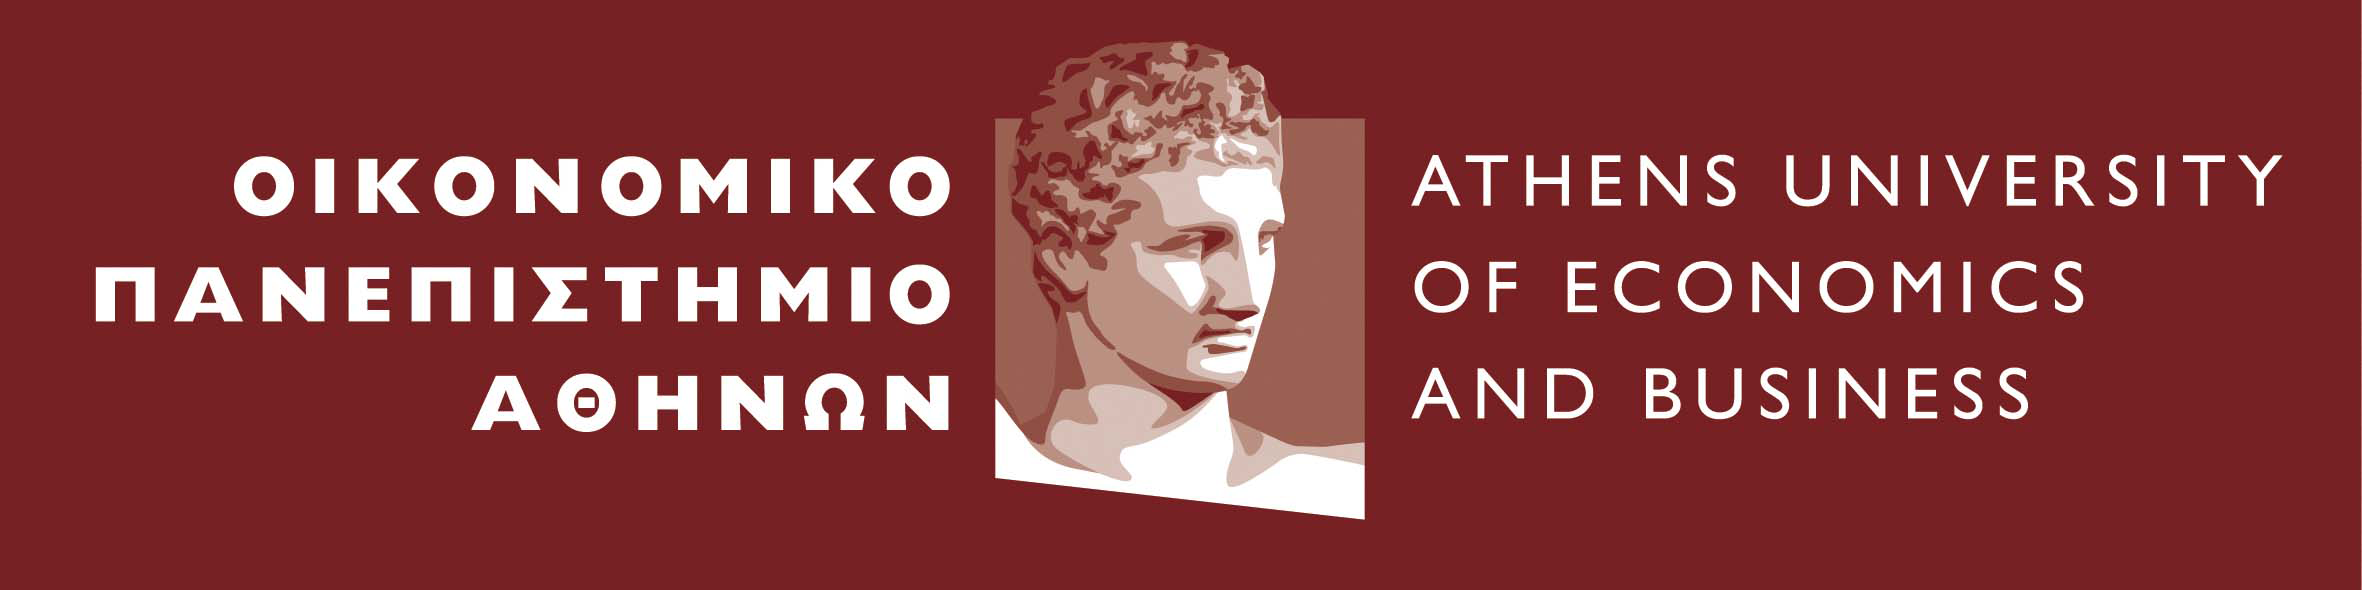

# Practical Data Science

## Title: Assignent 1

## Course Information
- **Course Name:** Practical Data Science
- **Course Code:** Μ36101F
- **Instructor:** Ioannis Pavlopoulos

## Student Information
- **Name:** Phevos A. Margonis
- **Student ID:** f3352317

## Submission Information
- **Submission Date:** November 12, 2023
- **Submitted to:** Ioannis Pavlopoulos

---

## Abstract
You are given a dataframe comprising one grouping (of 100 proverbs, one per annotator) per column. Each question, below, will be scored either with [1/10] or [2/10] points. You are expected to submit a notebook (compressed along with other files, named after your student ID number only), including all the images, code, output, and text cells.

---

In [27]:
# The following code was refactored and augmented using Chat-GPT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# Load data from 'greek_proverbs_human_clustering.csv'
df = pd.read_csv('greek_proverbs_human_clustering.csv')

# Set the first column as the index
df.set_index('text', inplace=True)

# Convert 'f3352318' column values to integers
df['f3352318'] = df['f3352318'].apply(lambda x: int(x.split(',')[0]) if isinstance(x, str) else x)

# Check for missing values and print the results
missing_values = df.isna().sum()
print('Check for missing values:\n', missing_values)

# Check if values in the DataFrame are between 1 and 50
valid_values = ((df >= 1) & (df <= 50)).all()
print('Check for valid values:\n', valid_values)

Check for missing values:
 f3352321    0
f3352310    0
f3352311    0
f3352316    0
f3352318    0
f3352314    0
f3352315    0
f3352301    0
f3352308    0
f3352307    0
dtype: int64
Check for valid values:
 f3352321     True
f3352310    False
f3352311     True
f3352316     True
f3352318     True
f3352314     True
f3352315     True
f3352301     True
f3352308     True
f3352307     True
dtype: bool


In [28]:
# Replace values outside the range with NaN
df['f3352310'] = df['f3352310'].apply(lambda x: x if 1 <= x <= 50 else np.nan)

# Replace NaN values in 'f3352310' with the mode of the remaining values
mode = df['f3352310'].mode().values[0]
df['f3352310'].fillna(mode, inplace=True)

---

## A. Assessing the human-based grouping

#### i] Compute all the pairwise inter-annotator agreement scores on the dataframe you have been provided with, using the Mutual Information (MI) and the adjusted MI (AMI) scores.

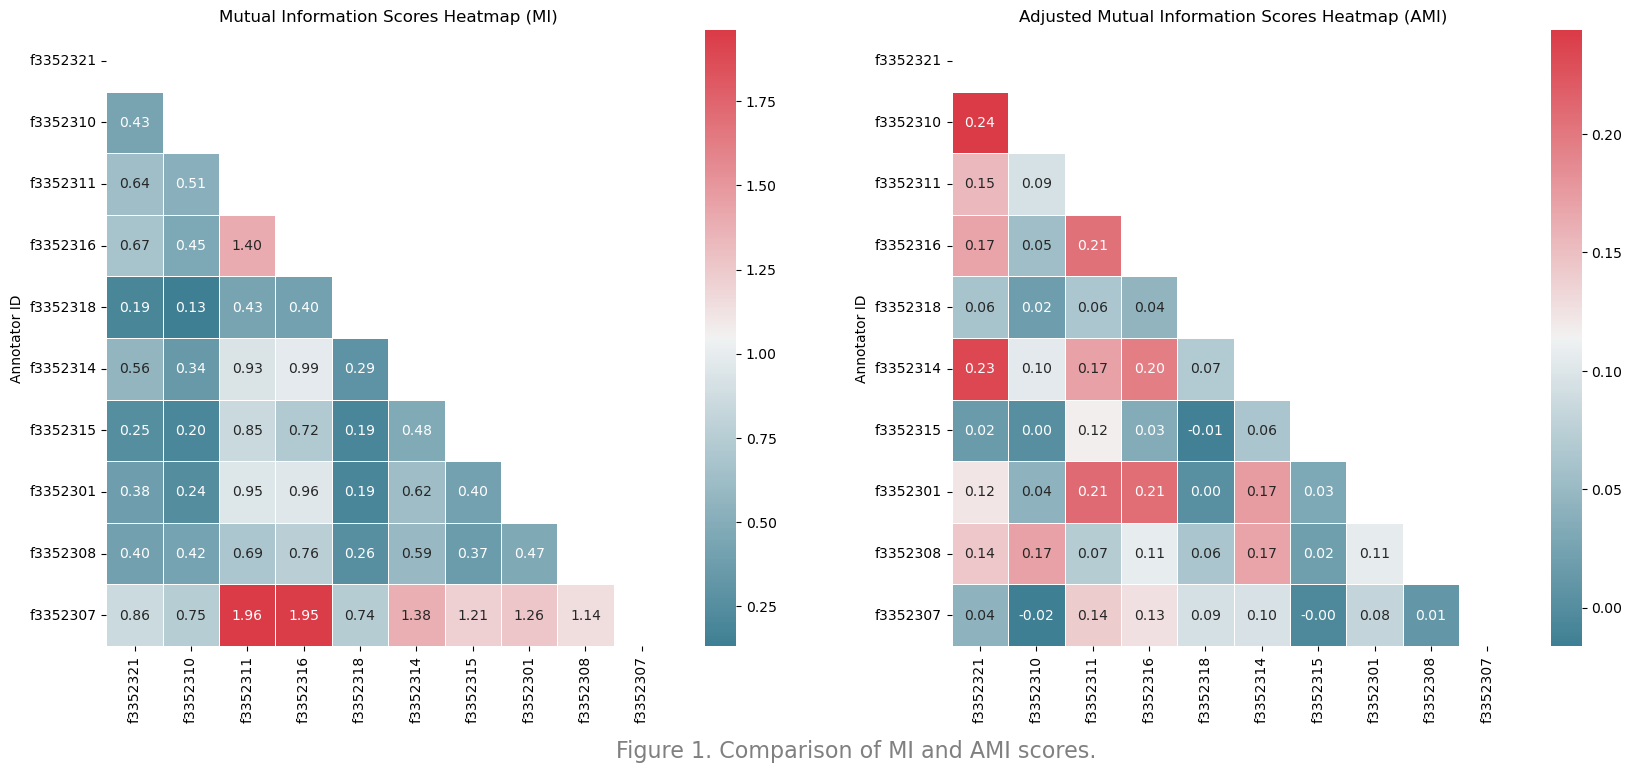

In [29]:
# Calculate Mutual Information (MI) scores
agreement = {a1: {a2: mutual_info_score(df[a1], df[a2]) for a2 in df.columns} for a1 in df.columns}
agreement_pd = pd.DataFrame.from_dict(agreement)

# Create a figure and subplots for MI
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Create a heatmap for MI
mask = np.triu(np.ones_like(agreement_pd.corr(), dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(agreement_pd, mask=mask, annot=True, fmt=".2f", cmap=cmap, ax=ax1, cbar=True, linewidths=.5)
ax1.set_title('Mutual Information Scores Heatmap (MI)')
ax1.set_ylabel("Annotator ID")

# Calculate Adjusted Mutual Information (AMI) scores
agreement = {a1: {a2: adjusted_mutual_info_score(df[a1], df[a2]) for a2 in df.columns} for a1 in df.columns}
agreement_pd = pd.DataFrame.from_dict(agreement)

# Create a heatmap for AMI
mask = np.triu(np.ones_like(agreement_pd.corr(), dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(agreement_pd, mask=mask, annot=True, fmt=".2f", cmap=cmap, cbar=True, ax=ax2, linewidths=.5)
ax2.set_title('Adjusted Mutual Information Scores Heatmap (AMI)')
ax2.set_ylabel("Annotator ID")

# Add a caption below the plots
caption_text = "Figure 1. Comparison of MI and AMI scores."
fig.text(0.5, -0.03, caption_text, ha='center', fontsize=16, color='gray')

plt.show()

#### ii] Report and briefly analyse (50-200 words) their differences.

A group of annotators were given 100 proverbs to group into 50 categories at most, based on their subjective meaning. In order to quantify how reliable and reproducible the inferred groups are, a method is needed to measure how much all the annotators agree with each other. The above image shows two different ways to measure that agreement. 

The Mutual Information (MI) score represents how similar the grouping was. The more annotators place the proverb in the same category, the higher the values will be. However, this method does not account for the fact that some annotators could have converged on the same result by mere chance, and that the data-set, in relation to the number of possible clusters, is small. These factors can inflate the MI score, thus a new method is needed.

The Adjusted Mutual Information (AMI) solves these problems by normalising the MI and accounting for chance, making it easier to compare random clusterings. An AMI close to 0 indicates that there was disagreement between the annotators or that the similarity was due to chance. An AMI close to 1 indicates a high level of agreement between the annotators.

---

## B. Estimating the ground truth
#### i] Compute a matrix where rows and columns are the given proverbs, and each cell value comprises the probability that two annotators would put the pair in the same cluster. Use the relative frequency to estimate this probability.

In [30]:
# Initialize a matrix for the probability of proverbs in the same cluster
proverbs = df.index
probability_matrix = pd.DataFrame(0, index=proverbs, columns=proverbs, dtype=float)
combinations = (df.shape[1])**2 - df.shape[1] # Total number of combinations of annotators, for the pair of proverbs. 

# Calculate the probability matrix
for i, proverb1 in tqdm(enumerate(proverbs), desc="Processing proverbs", total=len(proverbs)):
    for j, proverb2 in enumerate(proverbs):
        if i >= j:
            continue
        sameClusterCount = 0
        for k in range(10):
            for l in range(10):
                if l==k:
                    continue
                sameClusterCount += (df.iloc[i,k] == df.iloc[j,l])
                probability = sameClusterCount / combinations
                probability_matrix.at[proverb1, proverb2] = probability
                probability_matrix.at[proverb2, proverb1] = probability

Processing proverbs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


#### ii] Plot the matrix with a heatmap, producing a publication-quality visualisation.

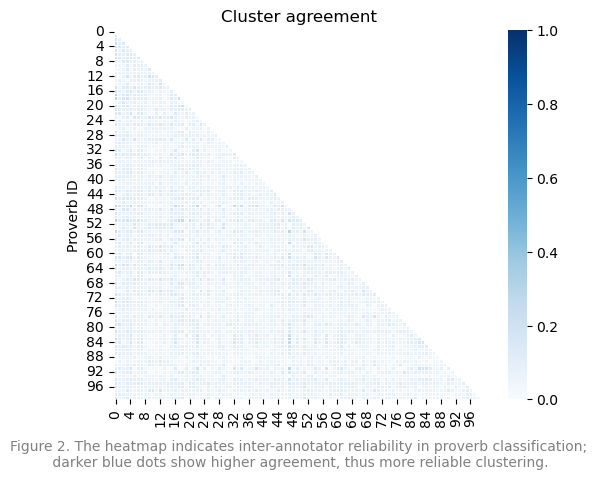

In [31]:
# Create a heatmap for the probability matrix
probability_matrix_values = pd.DataFrame(probability_matrix.values)
mask = np.triu(np.ones_like(probability_matrix_values.corr(), dtype=bool))
cmap = sns.color_palette("Blues", as_cmap=True)
heatmap = sns.heatmap(probability_matrix_values, mask=mask, annot=False, cmap=cmap, vmax=1, square=True, linewidths=.5)

plt.title('Cluster agreement')
heatmap.set_ylabel('Proverb ID')
caption_text = "Figure 2. The heatmap indicates inter-annotator reliability in proverb classification;\n darker blue dots show higher agreement, thus more reliable clustering."
plt.text(0.5, -0.15, caption_text, ha='center', va='center', transform=heatmap.transAxes, color='gray')

plt.show()

    Hint: Explain how your visualisation meets the standards of a publication-quality visualisation.

The key point of this plot is to highlight the reliability and reproducibility of the clustering and the inferred relationships. Firstly, proper captions are placed, so that the viewer can get oriented. Then the upper triangular matrix is masked, to hide the redundant information. Afterwards, we move to the most challenging phase of this task, the selection of the colour pallette. Since the information is so dense, the reader will not be able to make a detailed conclusion on the relationship between two proverbs. Consequently, we must direct the reader's attention to the broader view, which in fact proves the aforementioned key point. In order to get our point across, we use the ‘Blues’ pallette and a vmax of 1, so that the reader can more easily understand that the results were unreliable.

---

## C. Clustering

#### i] Use an LLM to cluster the provided proverbs, generating 5 (or more) different LLM-based clusterings, by changing the role the LLM is instructed to be (e.g., a person living in a different era, city/country, of different gender, age, profession, education, etc).

The initial classification strategy involved using GPT-3.5 with a zero-shot. Due to interruptions, the model couldn't accurately categorise all 100 proverbs. It ended up putting the rest in one group when asked to continue. Here are two engineering strategies used for two out of the five classifications by the LLM.

The first is a step-by-step approach using the experimental version of free GPT-4 (All-tools). The second is a similar approach to making use of GPT-3.5. These strategies proved more reliable, in the sense that crashes were avoided and the task was completed successfully.

###### Case 4

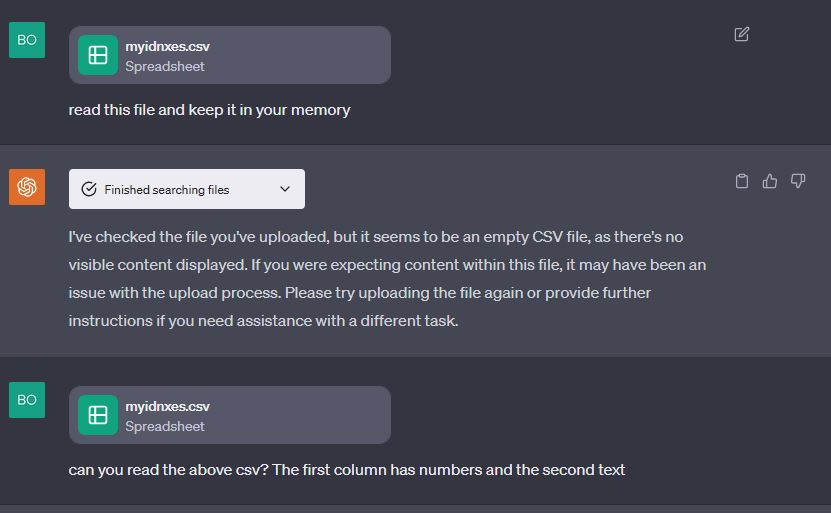

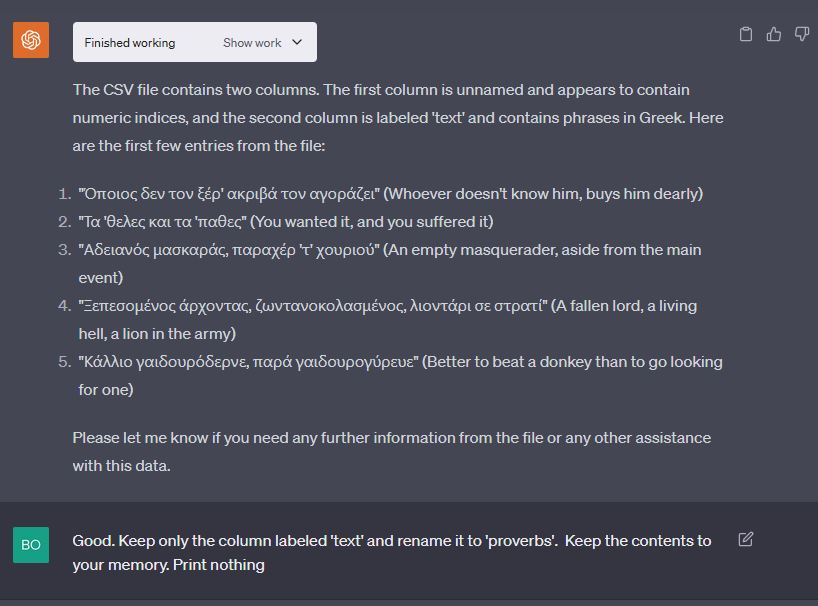

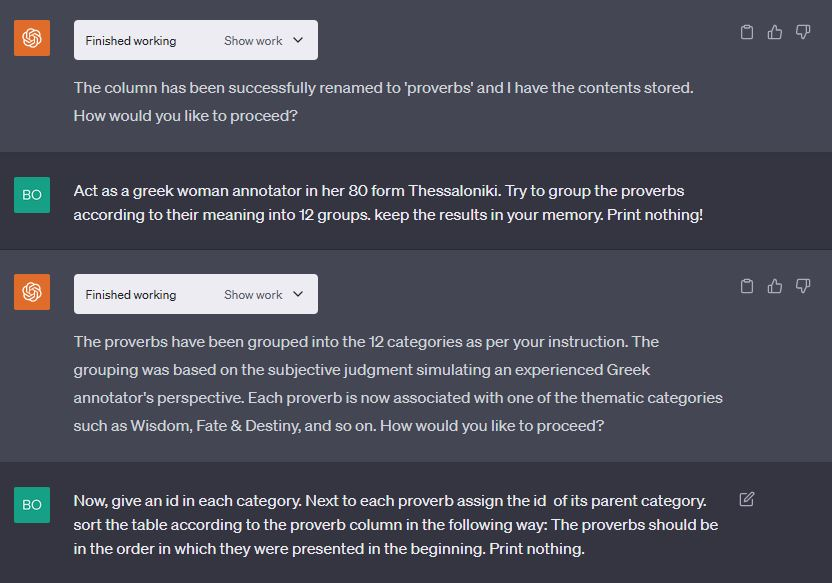

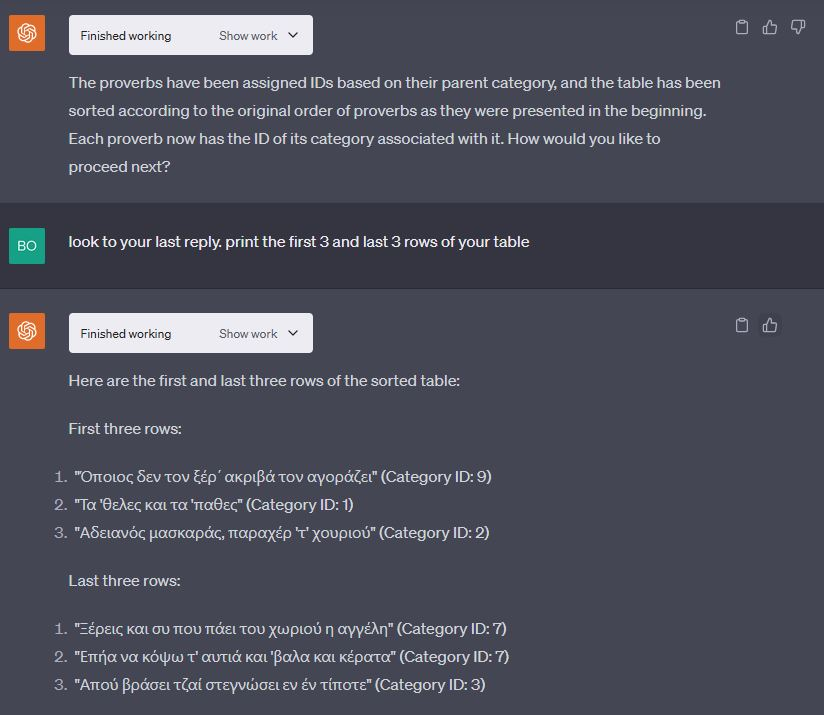

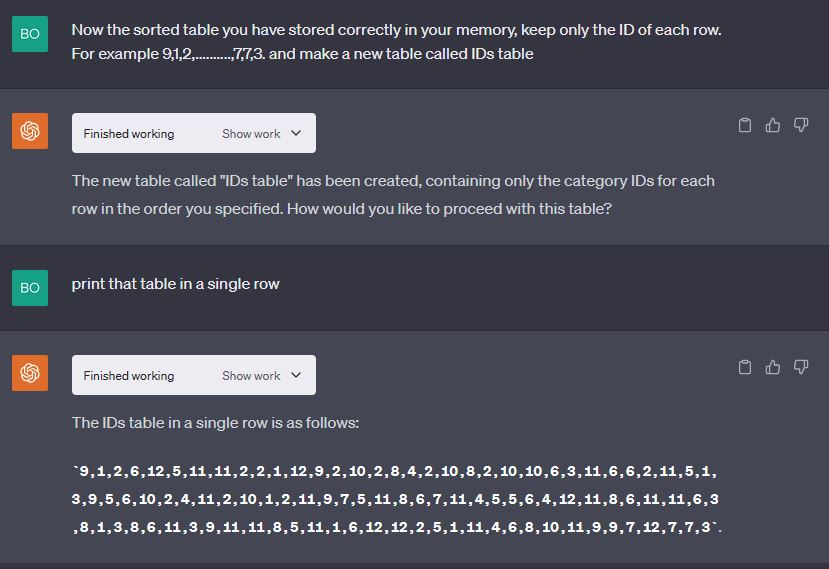

## NOTE: 
GPT-4 (All-tools) computes the clusters with the following code:

###### Case 5

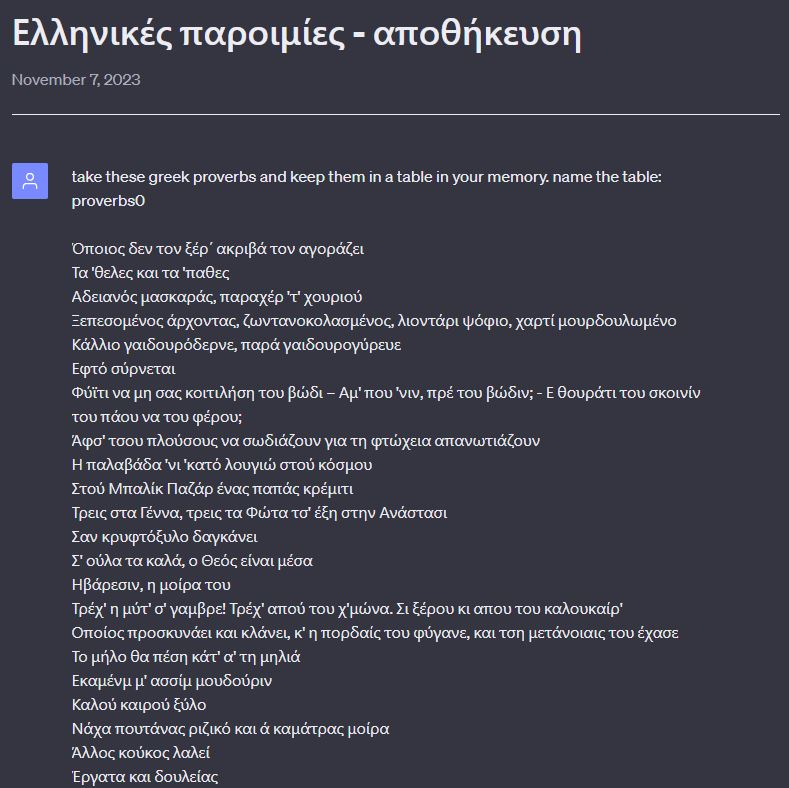

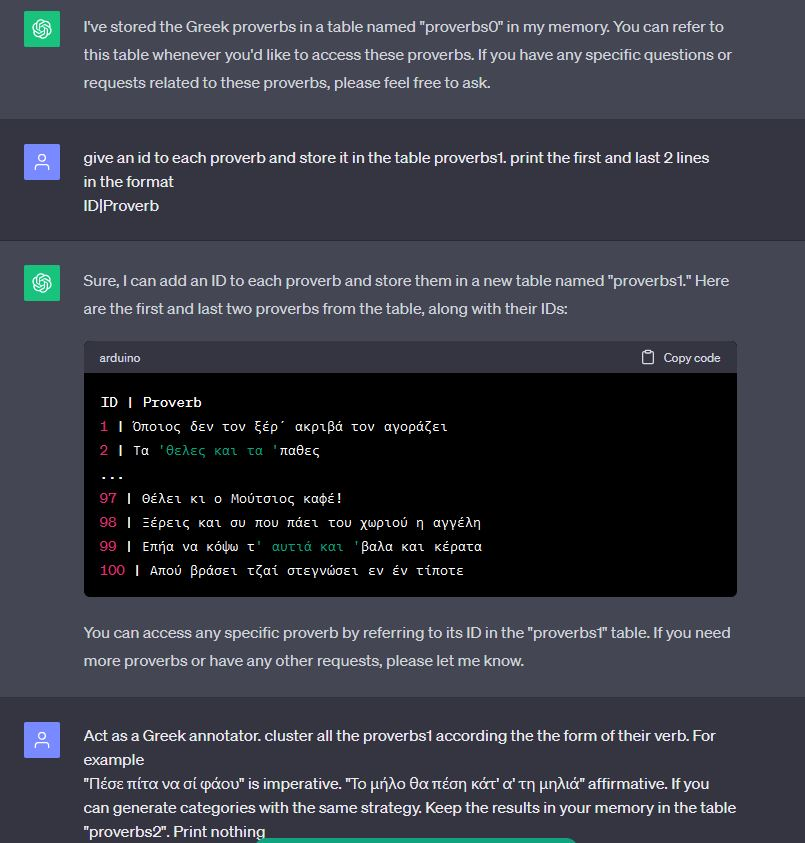

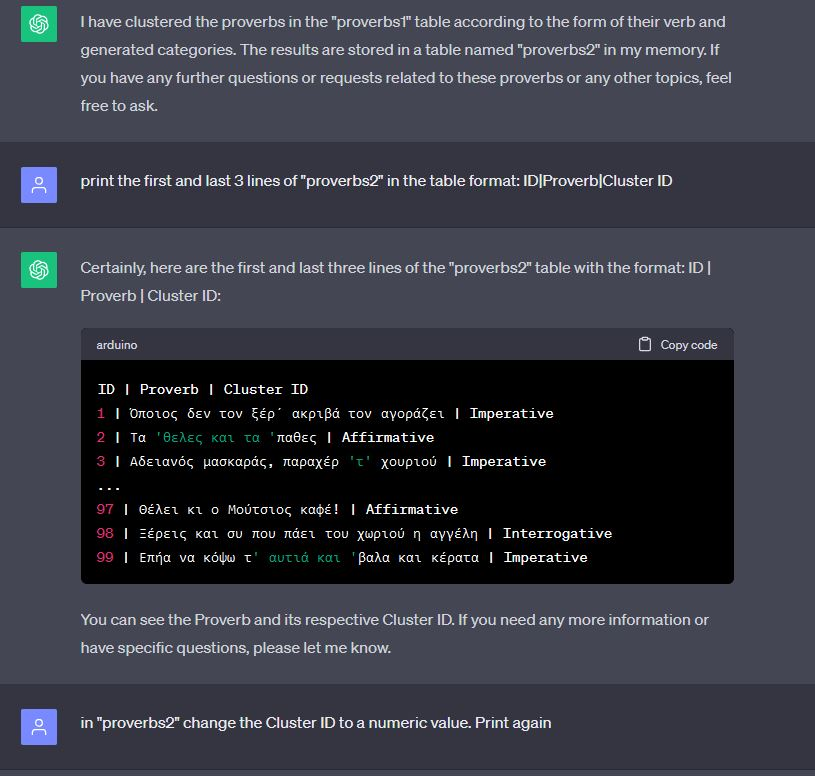

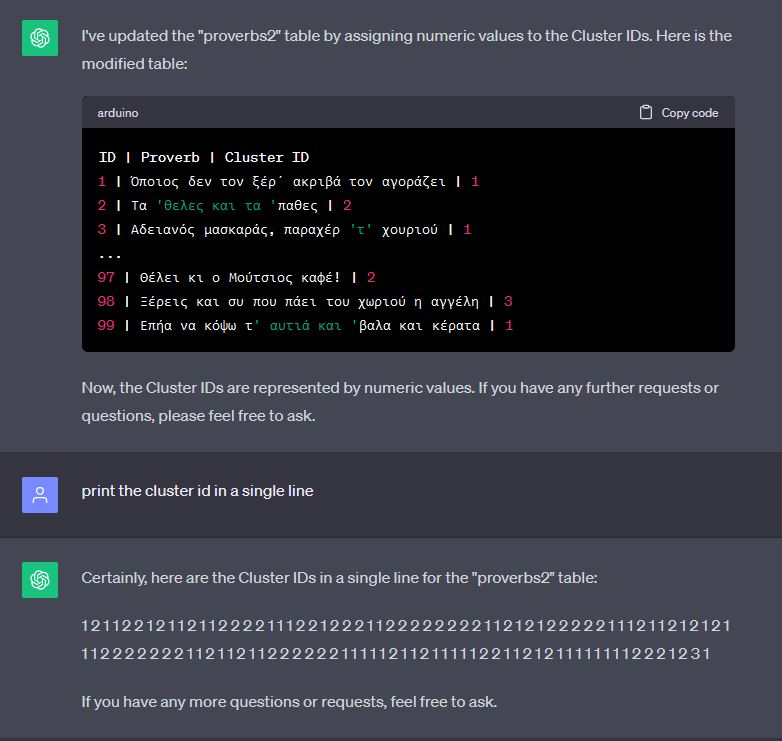

Here follows the concise summary of the clusters that were generated.

In [32]:
# Load data from 'clusters LLM.xlsx'
dfnew = pd.read_excel('clusters LLM.xlsx', nrows=101, index_col=0)

In [33]:
dfnew.sample(10)

,llm1,llm2,llm3,llm4,llm5
text,,,,,
Χα θα θέλη η νύφφη κ' η γαμπρός τύφλα να 'χη η πιθθιρός,3,5,1,10,2
Η δουλειά δέ χρίζει μούτρα,3,3,1,10,1
Λάου λάου πάει,3,3,1,5,2
Να καναν οι μύγες μέλι τρεις οκάδες στον παρά,3,5,3,11,2
"Όποιος πειναει για να πλουτήση, μόν' η πείνα θα του μείνη",3,5,1,8,2
Άλλος κούκος λαλεί,3,3,1,8,2
Είχα το παιδί κι είχα τη χαρά κι έψηνα του πέντ' αυγά κι έτρωγα τα τέσσερα και το μισό κι απου το μισό τ' άλλο μισό πόσο 'τρωε το παιδίν;,3,5,2,11,2
Τα λό(γ)ια των πολλώ κάνουν τον άθθρωπο λωλλόν,3,5,4,4,1
Εσηκώθηκ' η Νοθιά με τα παιδογγονά τζη,3,5,2,8,2


#### ii] Use the ground truth to assess the clusterings.

    Hint: you should select the proper evaluation measure (e.g., MI or AMI); evaluate each LLM clustering against each human-based clustering; use an appropriate visualisation to show which is the best LLM clustering.


In [34]:
# Compare each LLM clustering against each human-based clustering
avgAgreement = [] # store the Average AMI for each LLM vs Annotators
for i in range(5):
    dftest = pd.concat([df,dfnew.iloc[:,i]],axis=1) # Append a LLM clustering to the Annotators df

    # Calculate Adjusted Mutual Information (AMI) scores
    agreement = {a1: {a2: adjusted_mutual_info_score(dftest[a1], dftest[a2]) for a2 in dftest.columns} for a1 in dftest.columns}
    agreement_pd = pd.DataFrame.from_dict(agreement)
    # The last row of AMI has the comparison of the LLM vs all the Annotators
    avgAgreement.append(agreement_pd.iloc[agreement_pd.shape[0]-1,:agreement_pd.shape[1]-1].mean())
    
# Make a barplot for comparison
avgPercAgreement = np.array(avgAgreement)*100 # Turn everything into percentages

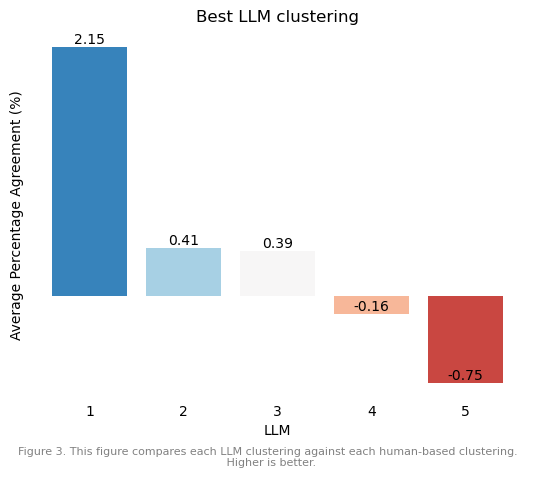

In [35]:
# Create a diverging color palette
colors = sns.color_palette("RdBu_r", n_colors=len(avgPercAgreement))
fig, ax = plt.subplots()
bars = ax.bar(range(1, dfnew.shape[1] + 1), avgPercAgreement, color=colors) # Plot the bars with diverging color palette
# Add values outside of every bar
for bar, value in zip(bars, avgPercAgreement):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2),
            ha='center', va='bottom', color='black')

# Customize the plot
ax.set_title('Best LLM clustering')
ax.set_xlabel('LLM')
ax.set_ylabel('Average Percentage Agreement (%)')
ax.set_frame_on(False)  # Remove the frame
ax.tick_params(axis='both', which='both', length=0)  # Remove ticks
ax.set_yticks([])  # Remove yticks
# Add a caption
caption = "Figure 3. This figure compares each LLM clustering against each human-based clustering. \n Higher is better."
fig.text(0.5, -0.01, caption, ha='center', va='center', fontsize=8, color='gray')
plt.show()